# Data Science Fundamentals 5

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2020

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 2.

In [1]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE
import umap

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

In [3]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [4]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [0.44009364] ;  b = 7.200335778689304


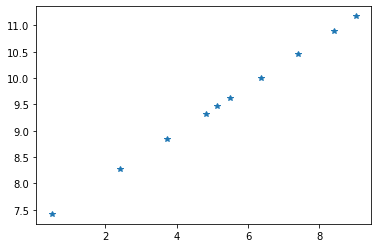

In [5]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

true slopes: w = [7.72771359 6.4169694 ] ;  b = 9.666507952940073


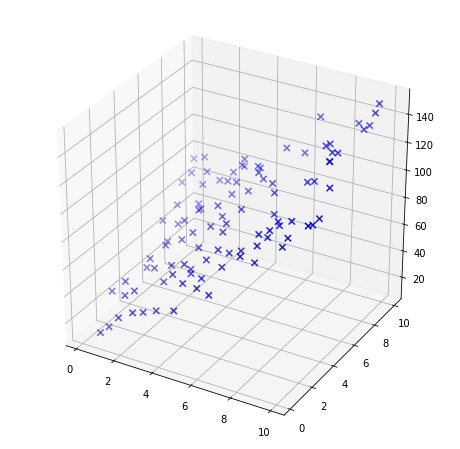

In [6]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [7]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [48]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

In [8]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


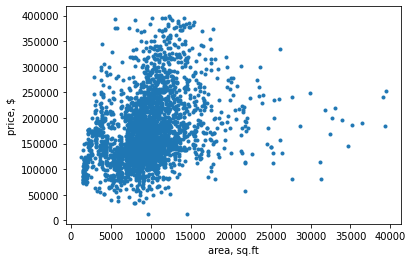

In [9]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

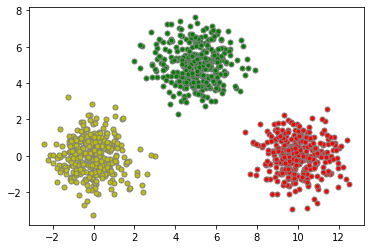

In [10]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [11]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

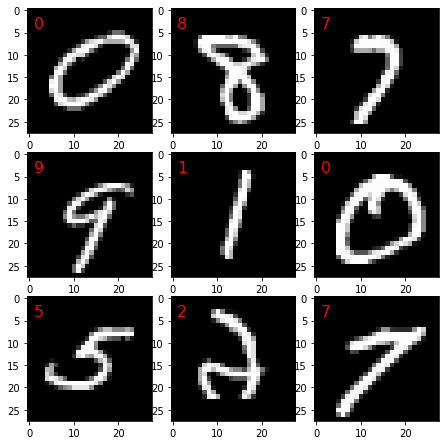

In [12]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)


## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

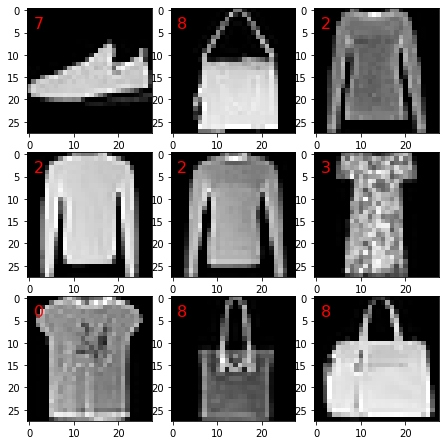

In [14]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

# 1. Trees & Forests

## 1. Decision Tree

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning **simple** decision rules inferred from the data features.

They are fast to train, easily interpretable and require small amount of data.

training score : 0.667 (depth=1)


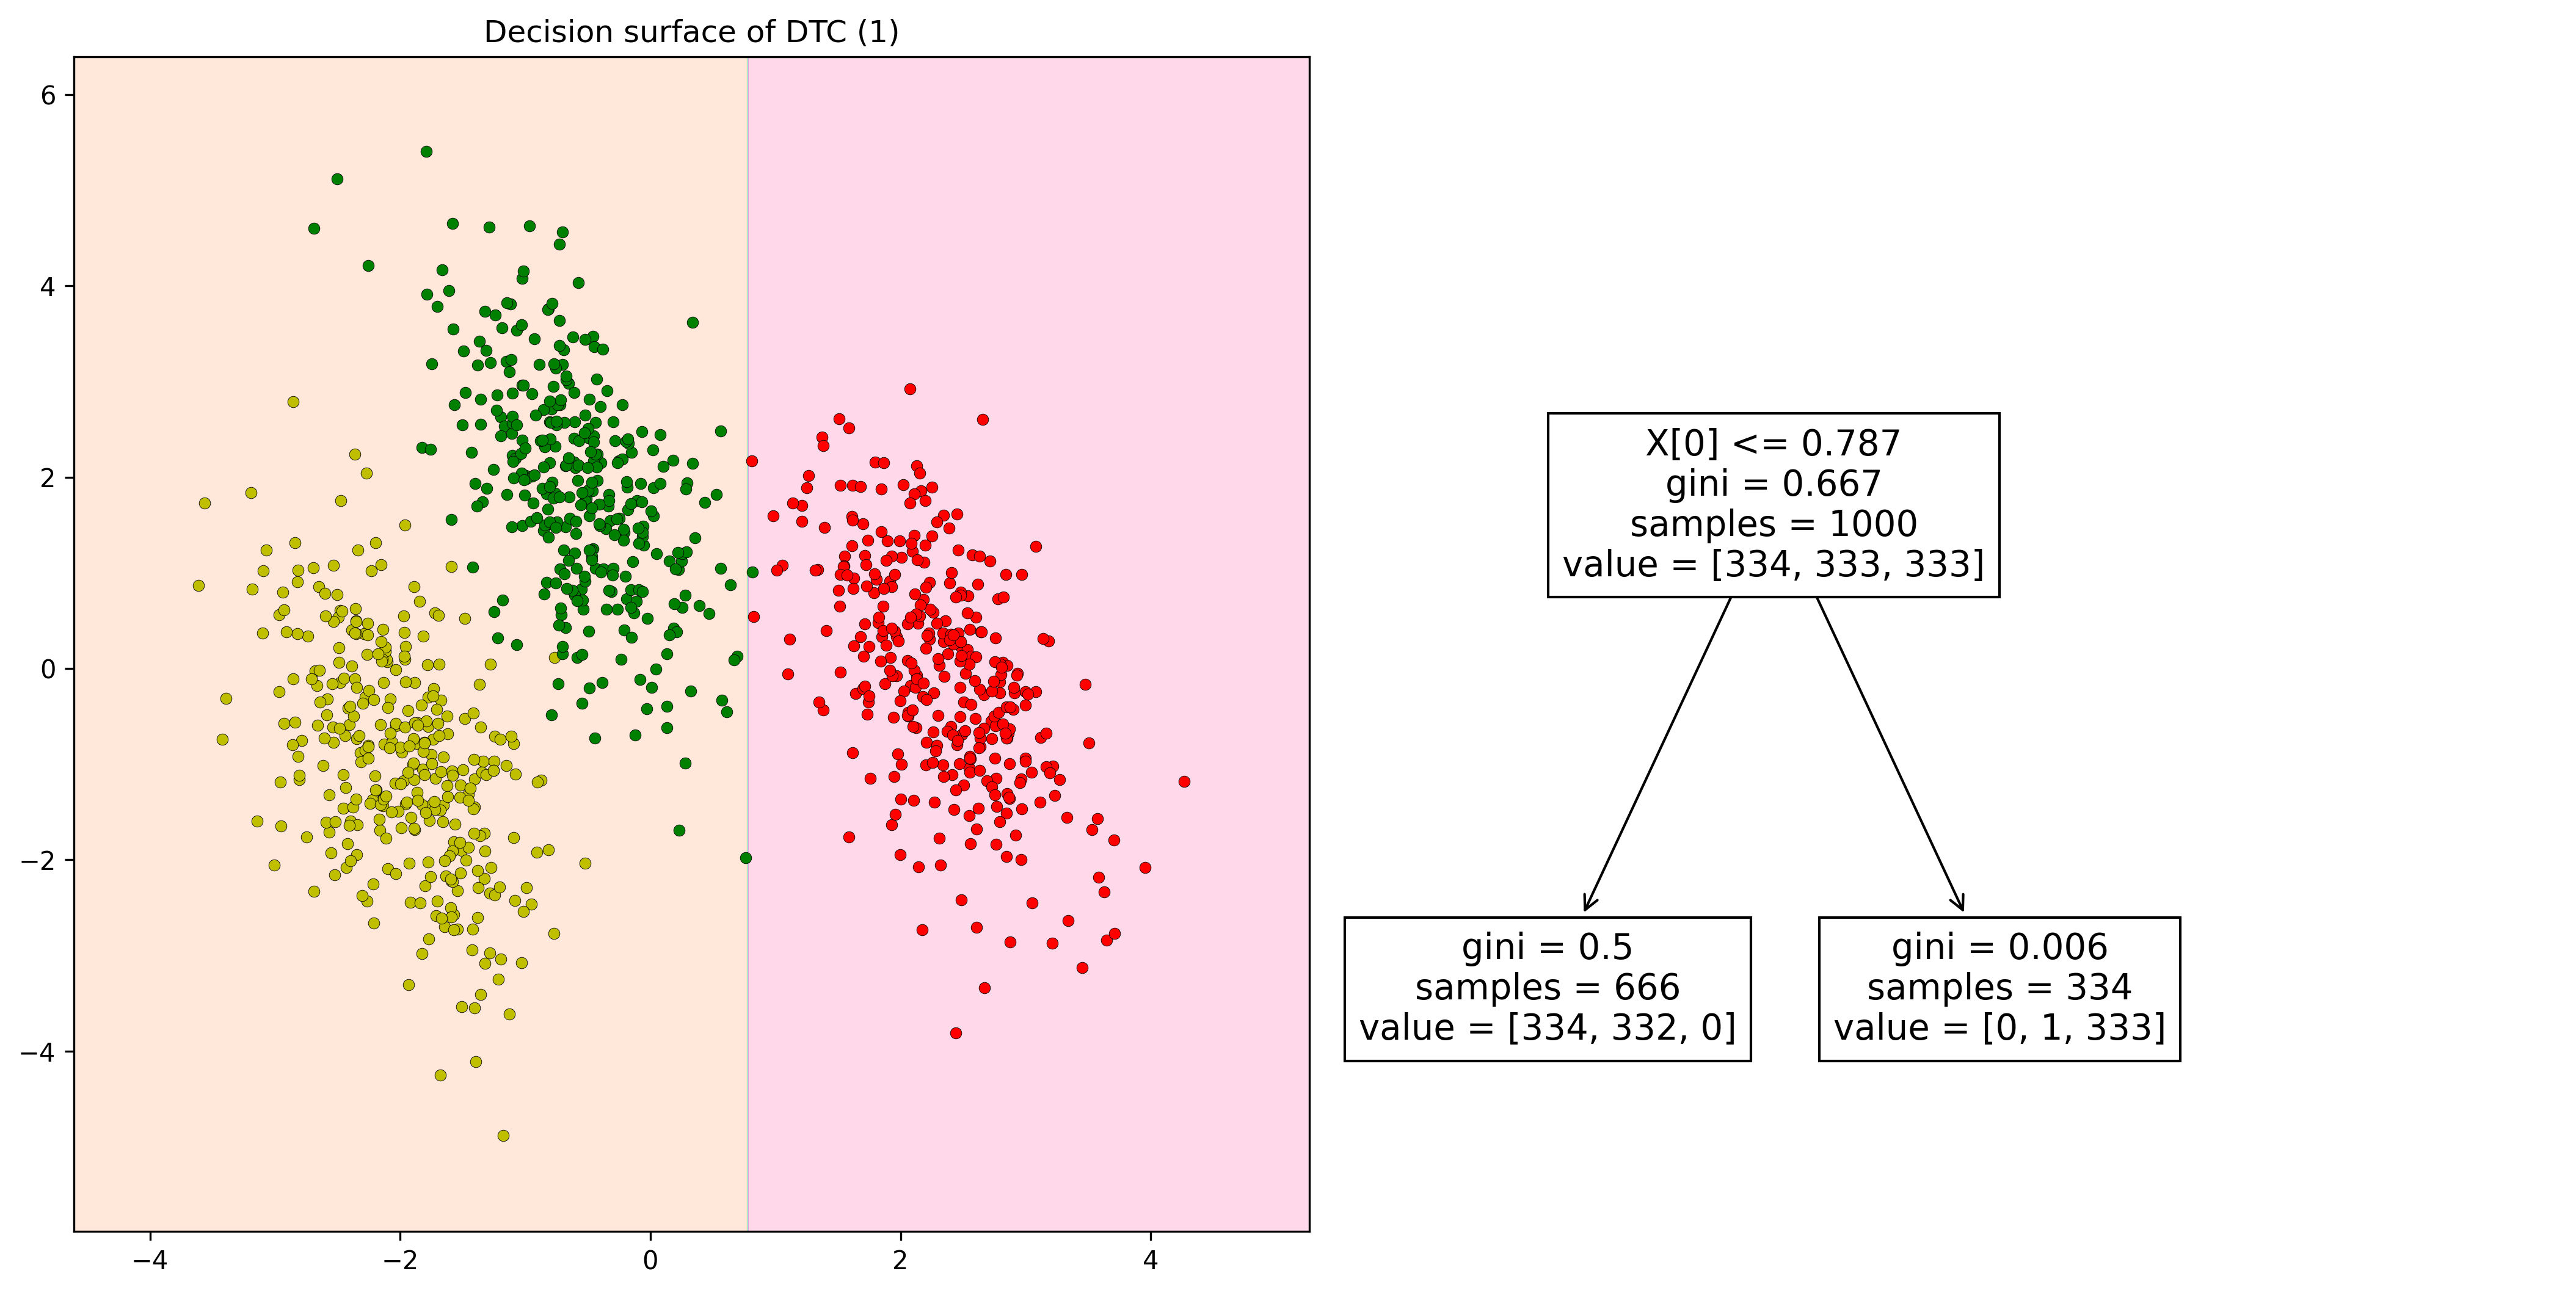

training score : 0.942 (depth=2)


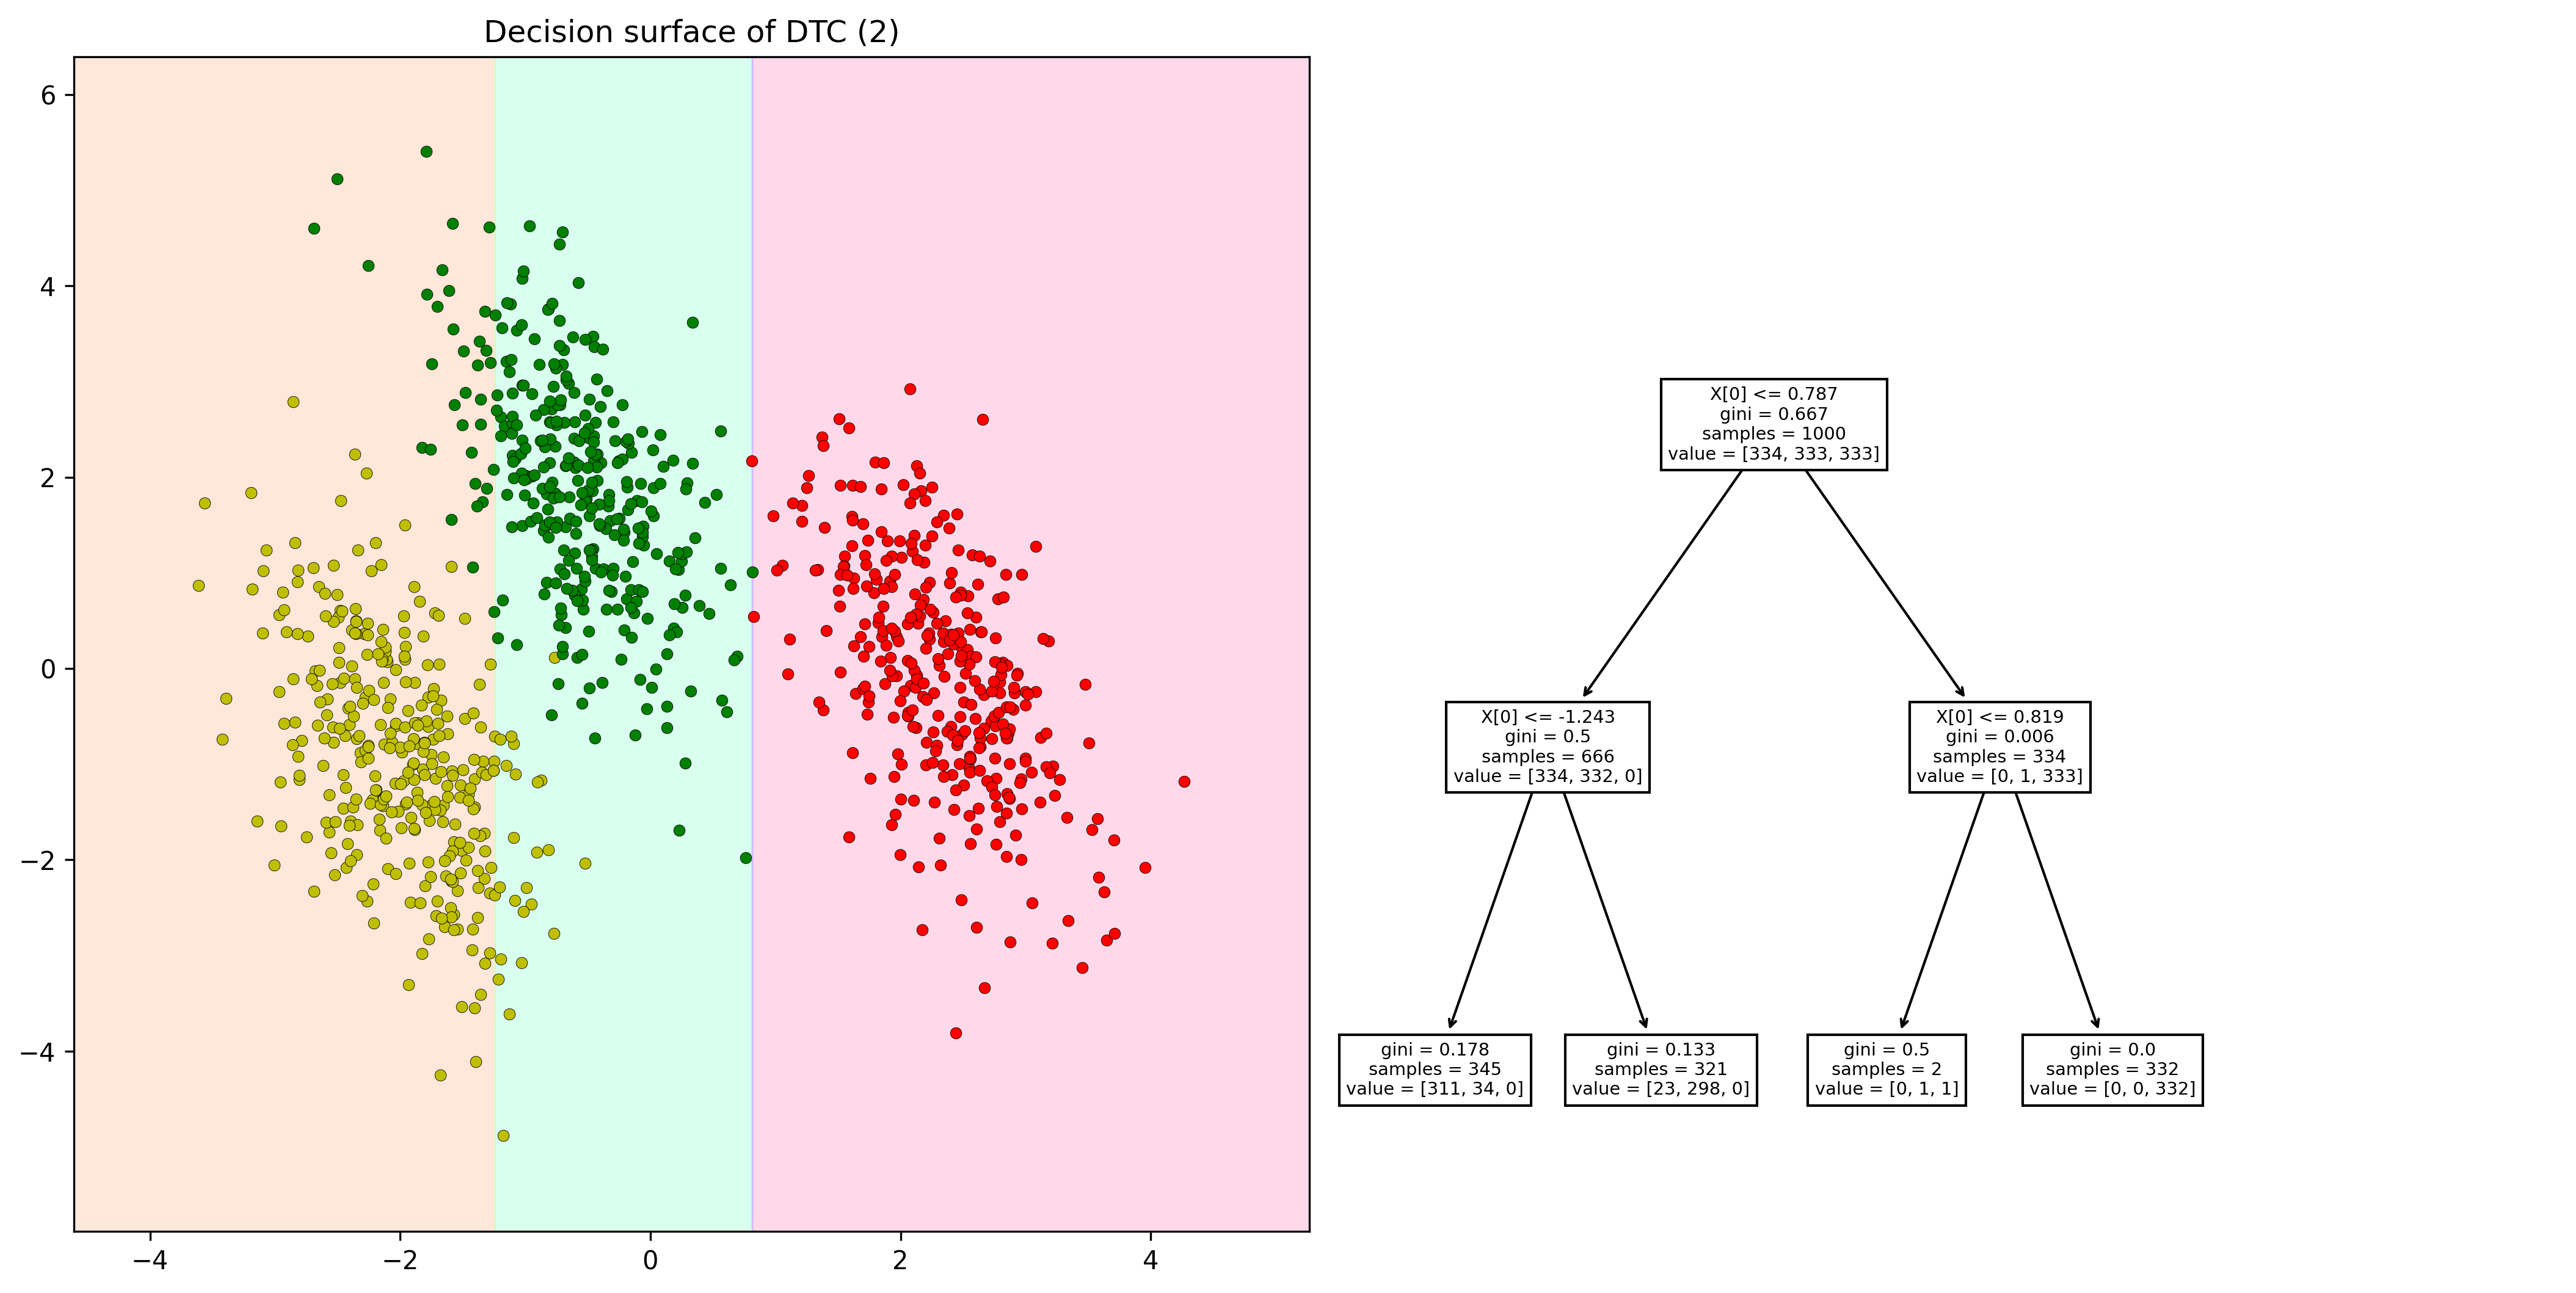

training score : 0.987 (depth=3)


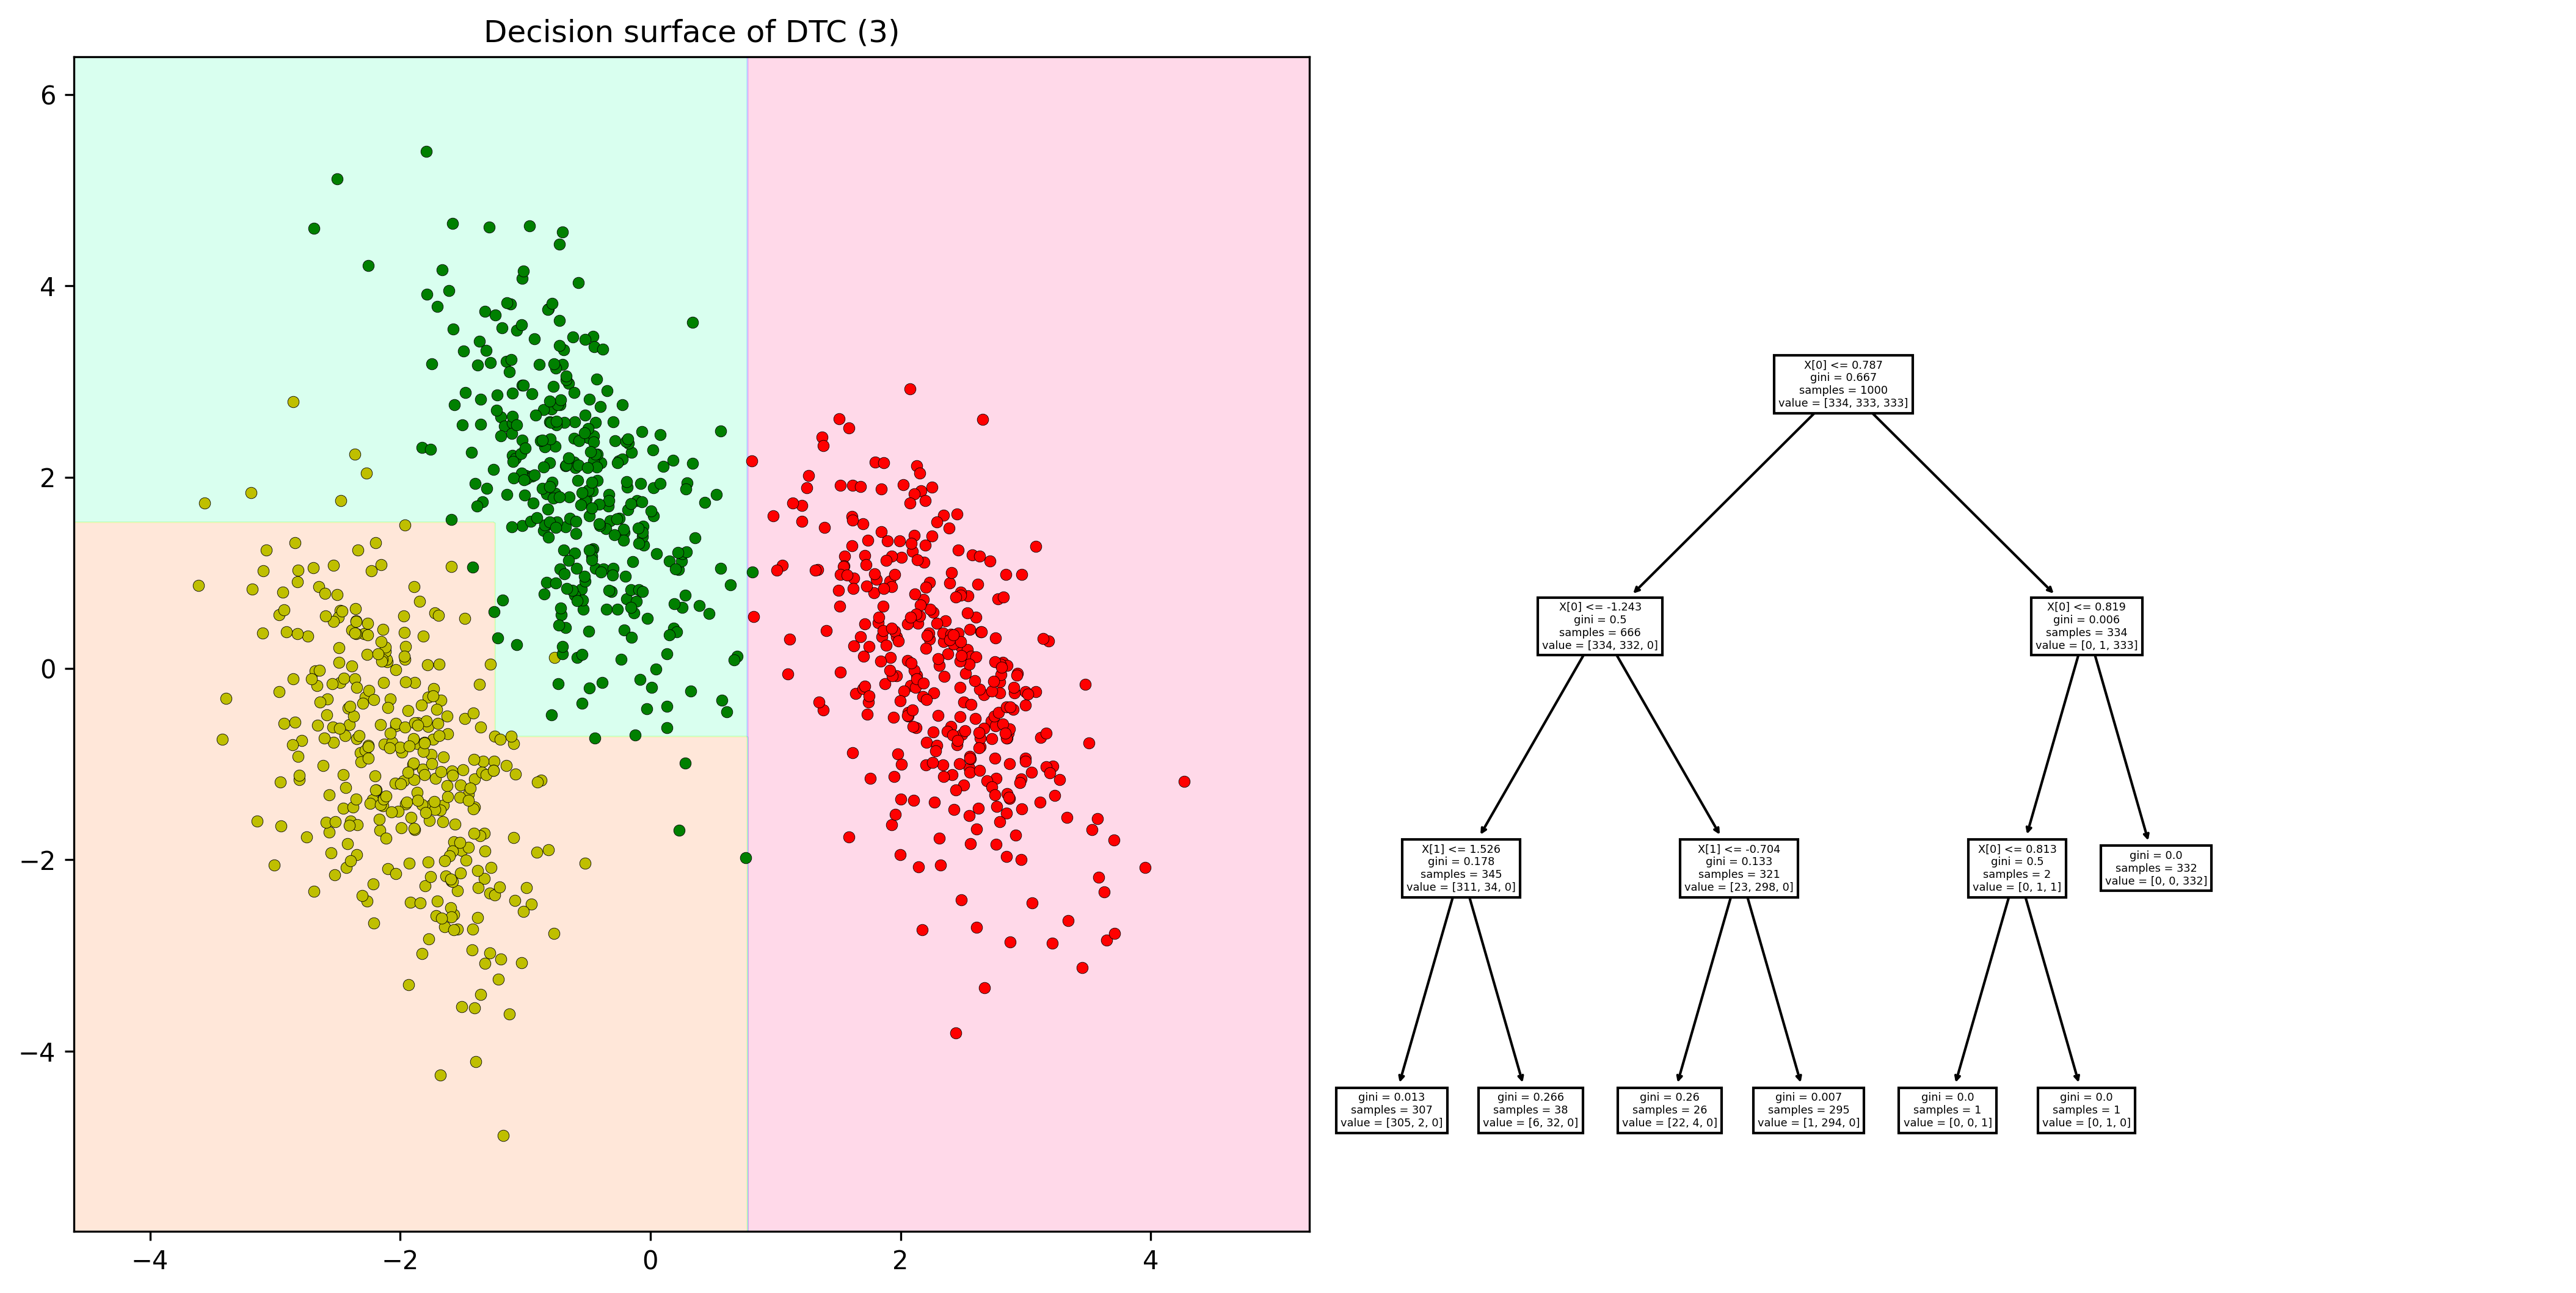

training score : 0.995 (depth=4)


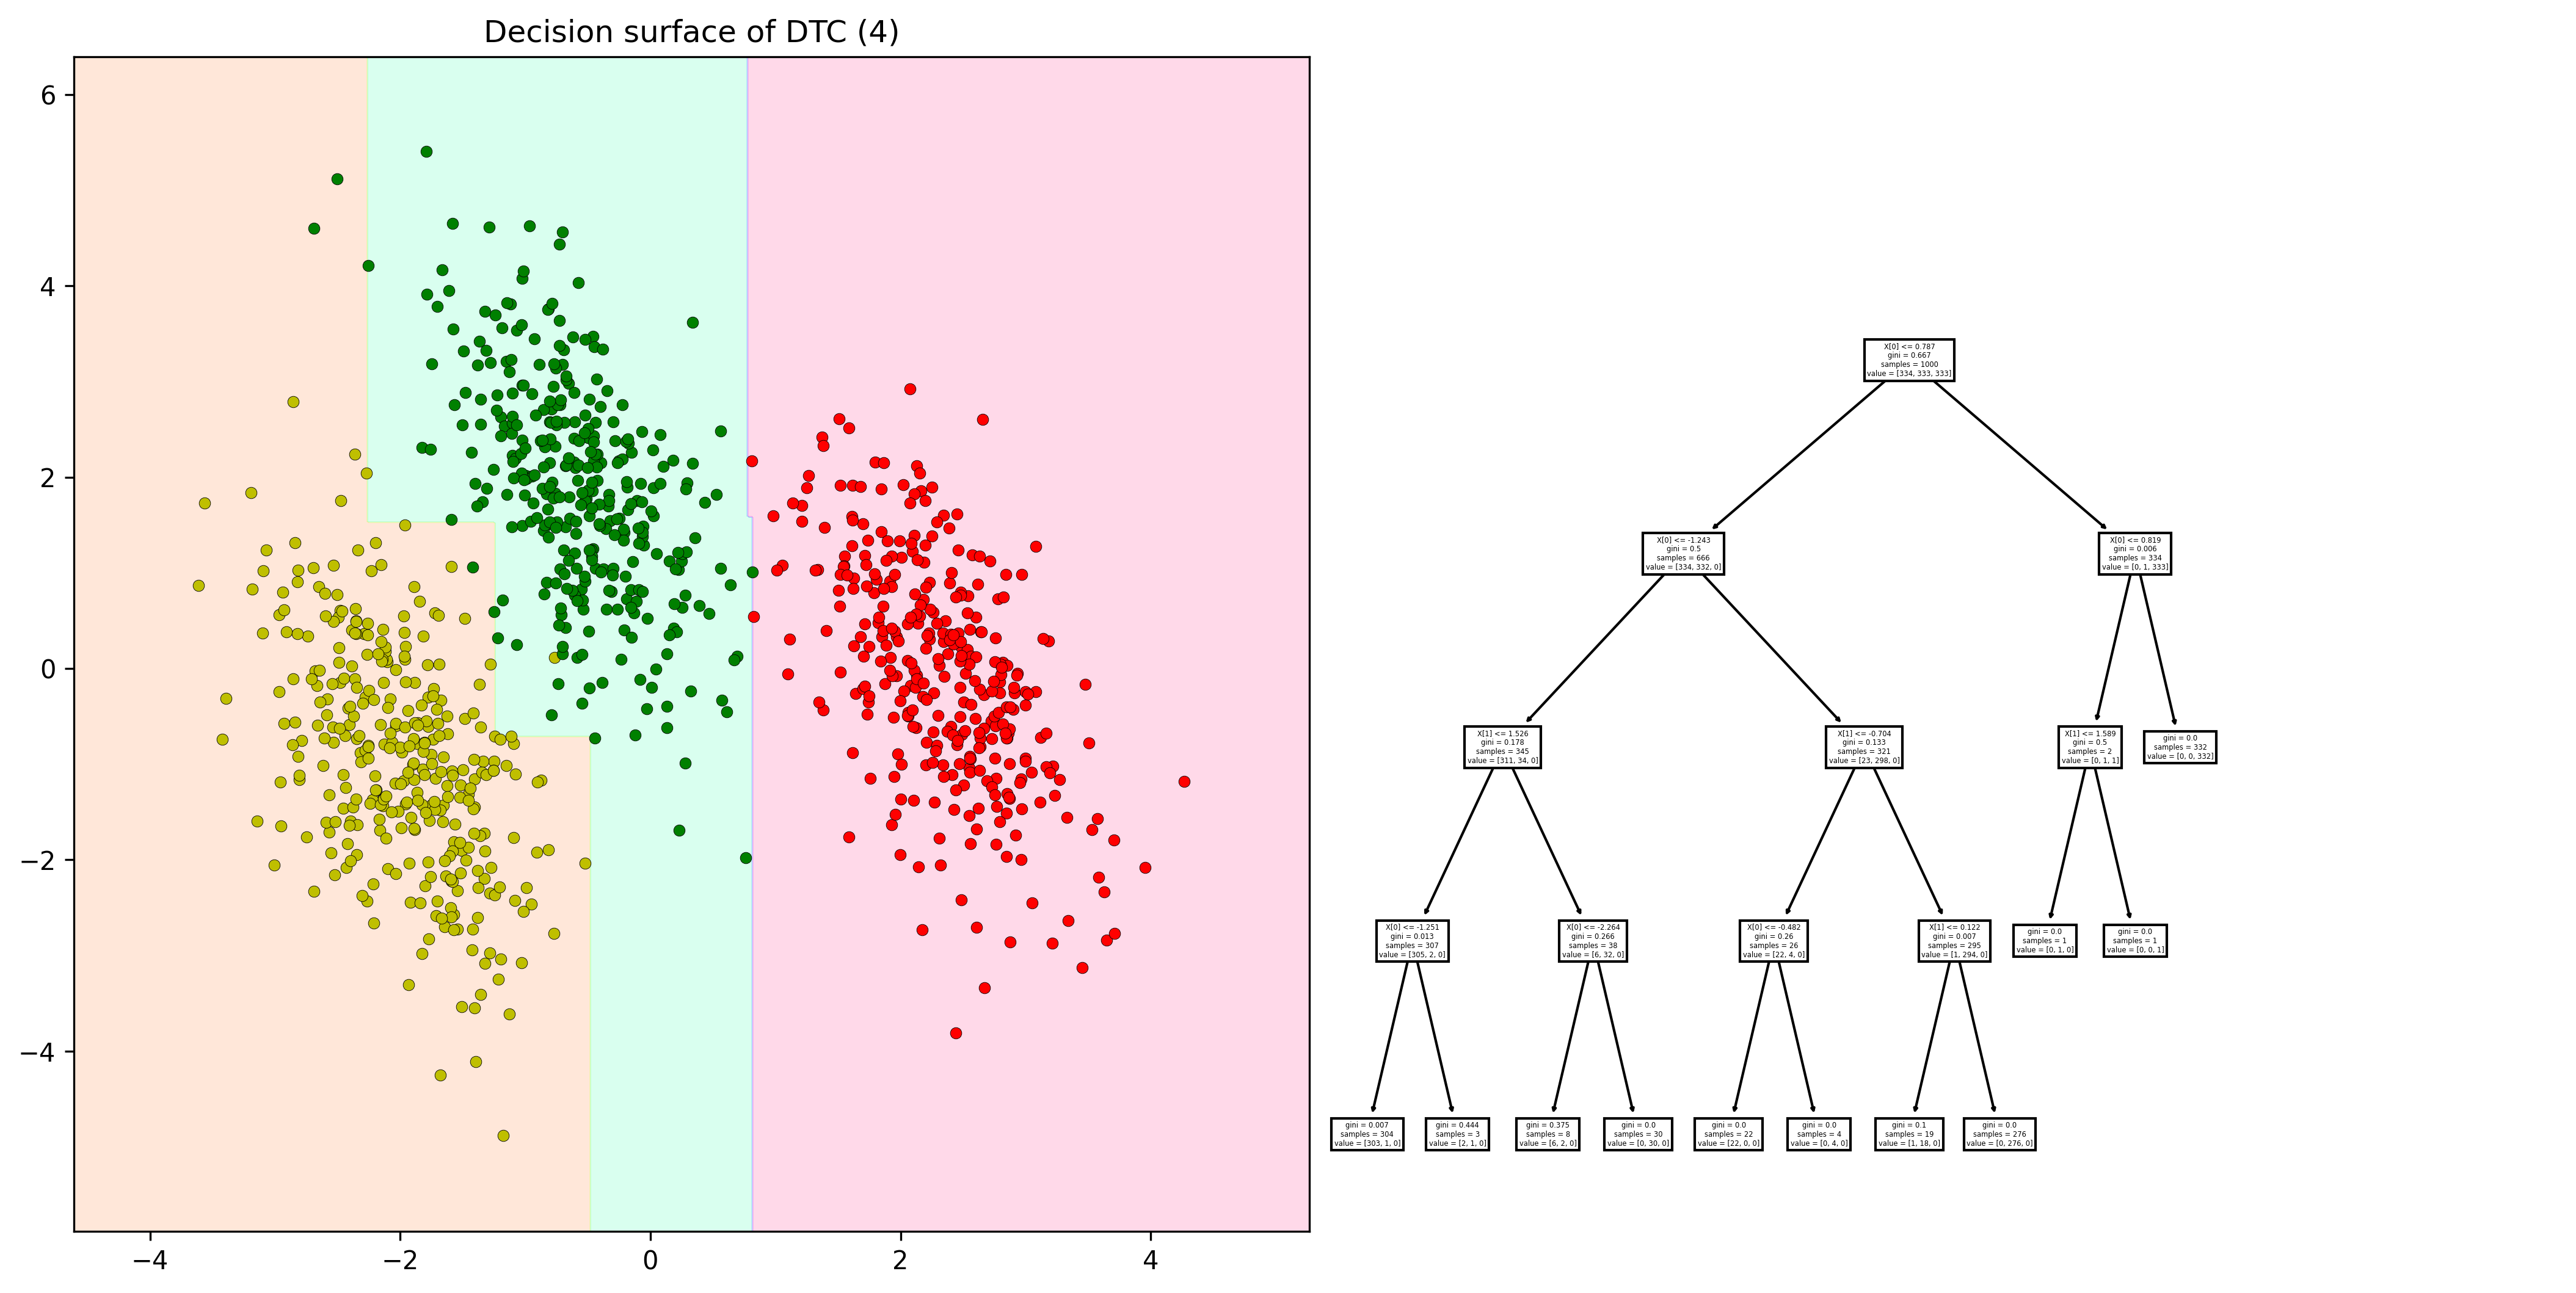

In [19]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
for depth in (1, 2, 3, 4):
    dtc = tree.DecisionTreeClassifier(max_depth=depth)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (depth=%d)" % (dtc.score(X, y), depth))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(1, 2,  figsize=(14,7), dpi=300)
    ax[0].contourf(xx, yy, Z, cmap='hsv', alpha=0.15)
    ax[0].set_title("Decision surface of DTC (%d)" % depth)
    
    # Plot also the training points
    colors = "ygr"
    for i, color in zip(dtc.classes_, colors):
        idx = np.where(y == i)
        ax[0].scatter(X[idx, 0], X[idx, 1], c=color,
                    edgecolor='black', s=20, linewidth=0.2)

    tree.plot_tree(dtc, ax=ax[1]);

    plt.tight_layout(0.5,0)
    plt.show()

## 2. Random Forest

The `sklearn.ensemble` provides several ensemble algorithms. RandomForest is an averaging algorithm based on randomized decision trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

Individual decision trees typically exhibit high variance and tend to overfit.
In random forests:
* each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.
* when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset.

The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant, hence yielding an overall better model.


training score : 0.831 (n_est=1)


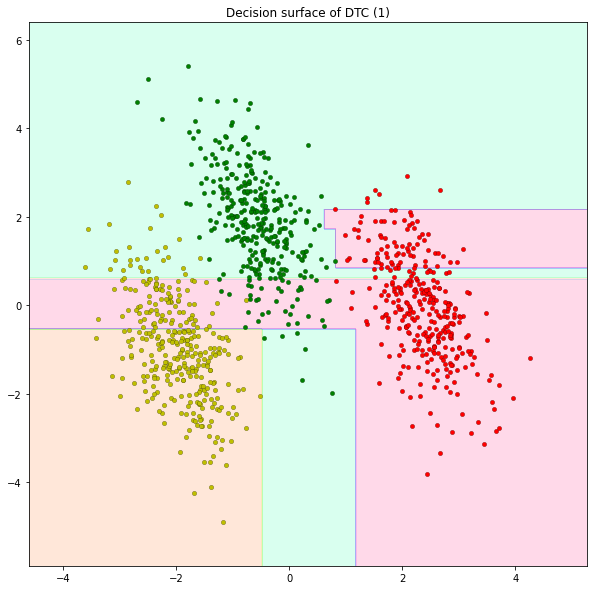

training score : 0.988 (n_est=4)


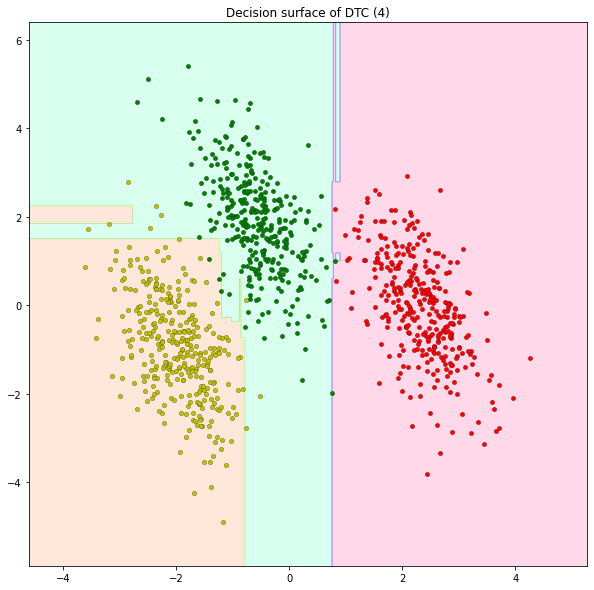

training score : 0.997 (n_est=50)


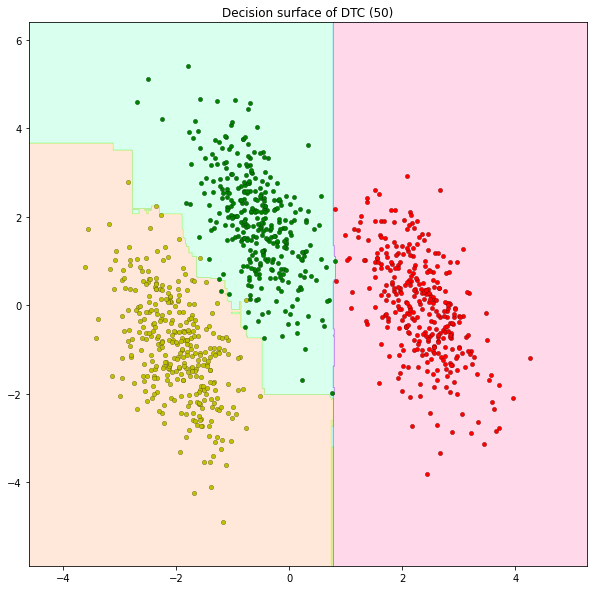

In [18]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    dtc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=n_est)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap='hsv', alpha=0.15)
    plt.title("Decision surface of DTC (%d)" % n_est)
    plt.axis('tight')

    # Plot also the training points
    colors = 'ygr'
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,
                    edgecolor='black', s=20, linewidth=0.2)
    
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()


    plt.show()

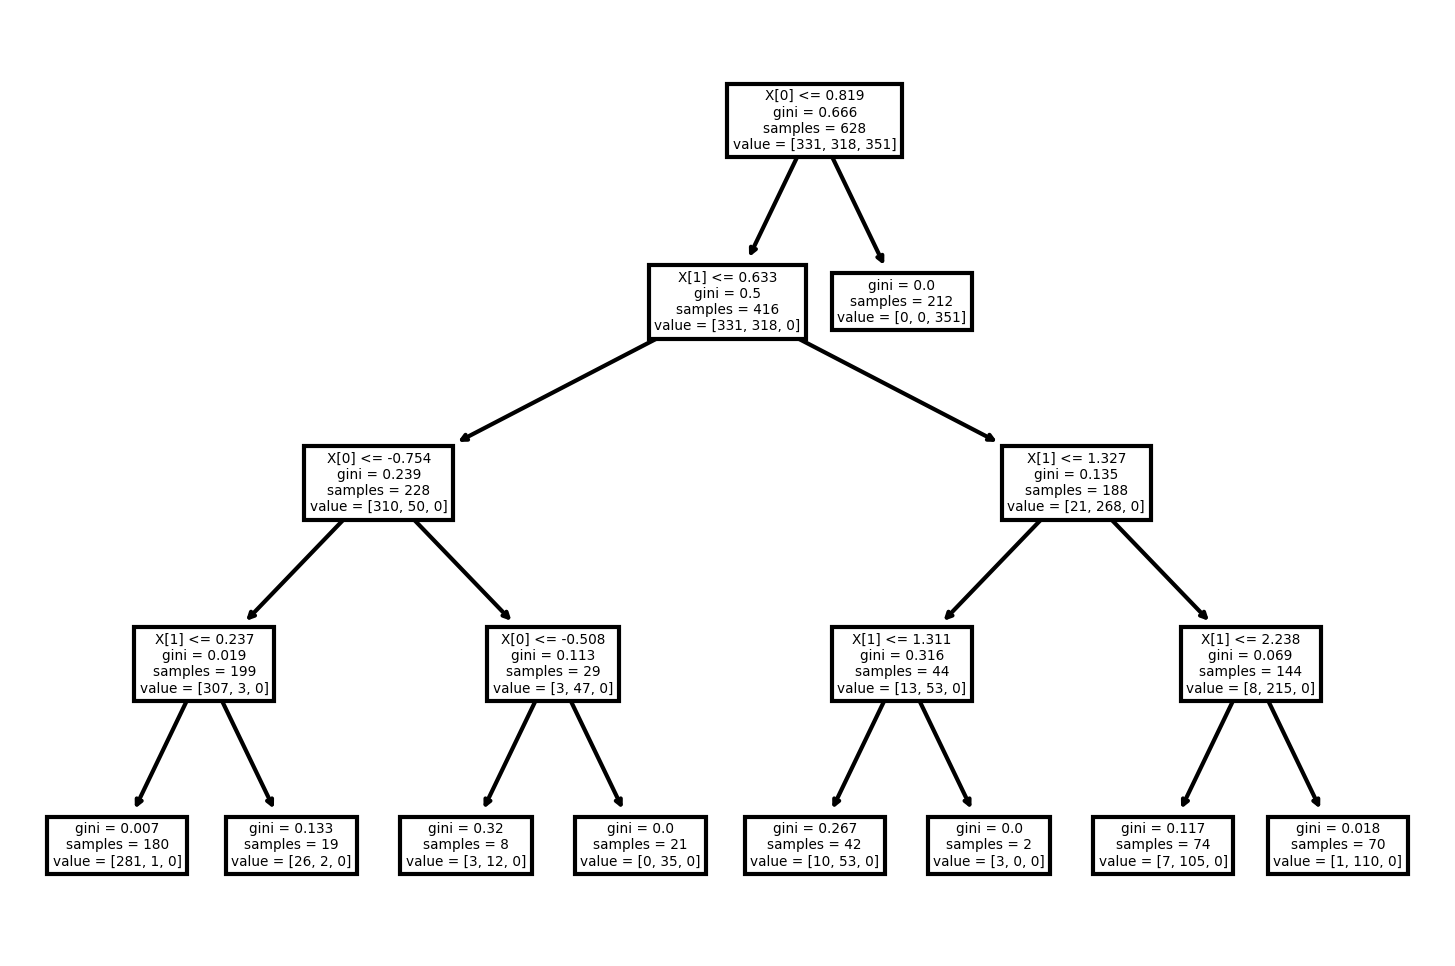

In [ ]:
plt.figure(dpi=300)
tree.plot_tree(dtc.estimators_[20]);

## 3. Boosted Decision Trees

Another approach to the ensemble tree modeling is Boosted Decision Trees. Generally, in a boosting framework, the next member of the ensemble of models is chosen to correct iteratively the mistakes currently performed.

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is an implementation of boosting able to deal with arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

Boosting is based on weak learners, e.g. shallow trees. In boosting primarily the bias is reduced.

training score : 0.942 (n_est=1)


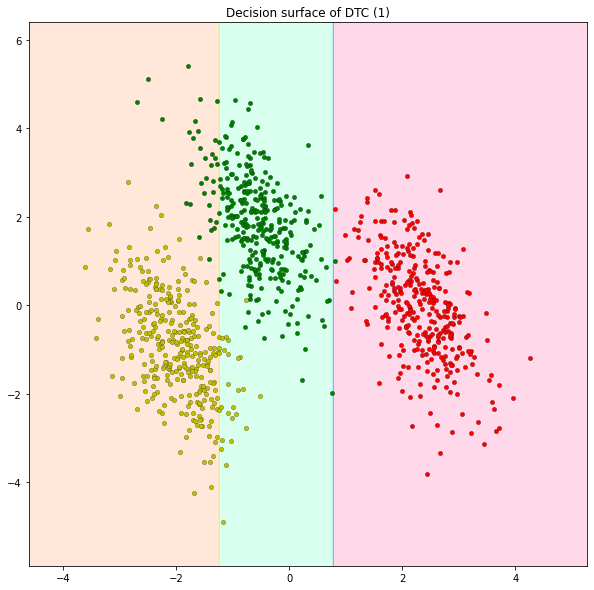

training score : 0.944 (n_est=4)


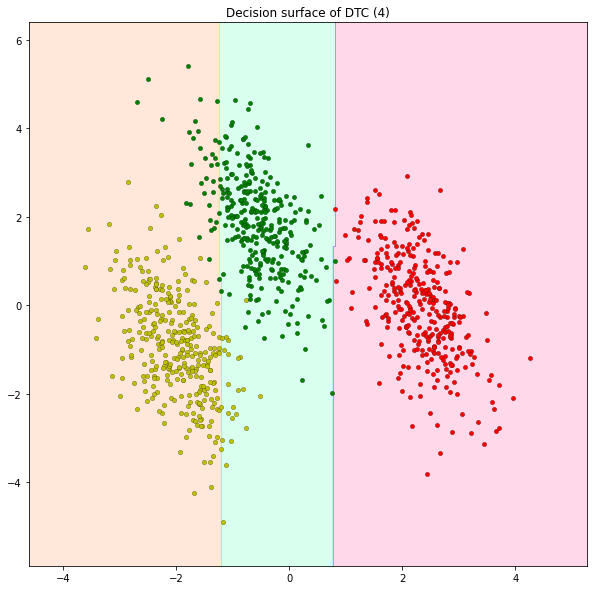

training score : 0.994 (n_est=50)


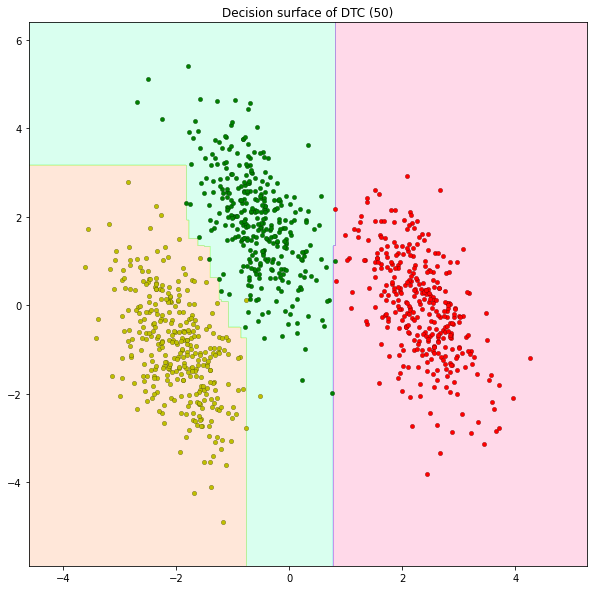

In [55]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap='hsv', alpha=0.15)
    plt.title("Decision surface of DTC (%d)" % n_est)
    plt.axis('tight')

    # Plot also the training points
    colors = 'ygr'
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,
                    edgecolor='black', s=20, linewidth=0.2)
    
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()


    plt.show()

## EXERCISE 1 : Random forest classifier for FMNIST


In [24]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

n = len(train_labels)
x_train = train_images.reshape((n, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

Classify fashion MNIST images with Random Forest classifier.

In [25]:
# 1. Create classifier. As the number of features is big, use bigger tree depth 
# (max_depth parameter). in the same time to reduce variance, one should limit the
# total number of tree leaves. (max_leaf_nodes parameter)
# Try different number of estimators (n_estimators)

# 2. fit the model
# 3. Inspect training and test accuracy

# 2. Unsupervised Learning Techniques


## 1. Principal Component Analysis (PCA)

### Theory overview.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features.

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ; 
- uncorrelated between each other ; 

If $M \ll D$ we get an effective dimensionality reduction.

**Methods:** Each data point indexed by $p=1..N$ can be seen as an element $\mathbf{x}_p \in \mathbf{R}^D$. 

The variance of the data-cloud measures the spread around its centroid:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  ( \mathbf{x}_p - \mathbf{\overline{x}})^2$$
$$\mathbf{\overline{x}}=\frac{1}{N}\sum_{p=1}^{N} \mathbf{x}_p$$

We fix a number $1\le k \le D$ and consider a subspace $V_k$ of dimension $k$. Each data point  $\mathbf{x}_p$ is projected onto $V_k$, leading to points $\mathbf{x}^k_p$ with spread $S^{2,k}$.  PCA chooses $V_k$ such that the variance $S^{2,k}$ is maximized, as shown in the picture.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

**Terminology and output of a PCA computation:** 
- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$ spanning optimal subspaces: $\text{Span}\{k_1,..,k_m\}=V_m$ ; 
- `Scores`: For every sample-point $p$. the new features are called scores are given by the component of $p$ along the $k$ vectors;  
- `Reconstructed vector`: For every $k$, the projection of $V$ on $V_k$ ;
- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*

### Sklearn: implementation and usage of PCA.

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

We have  30 samples of dimension  2


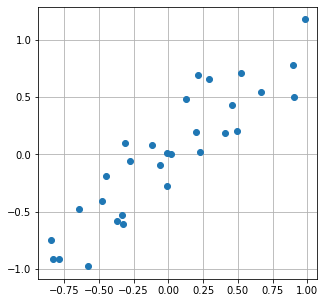

In [26]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [27]:
pca=PCA(n_components=2) 

A call to the pca.fit method computes the principal components

In [28]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

(-2.0, 2.0)

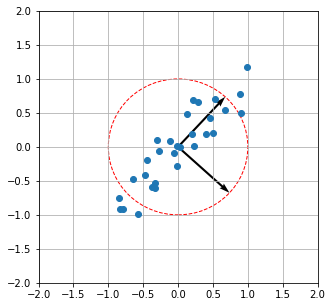

In [29]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [30]:
print(pca.explained_variance_ratio_)

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

In [31]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

(-1.0, 1.0)

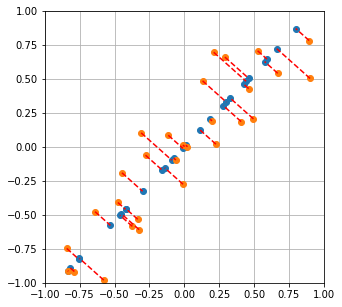

In [32]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

In [33]:
high_dim_dataset=load_multidimensional_data_pca(n_data=40 ,n_vec=6, dim=20, eps= 0.5)
n_samples,n_dim=high_dim_dataset.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

We have  40 samples of dimension  20


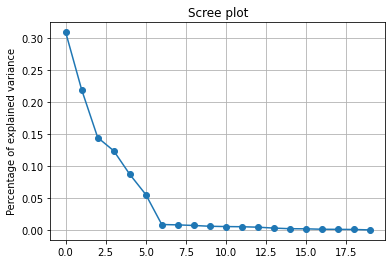

In [34]:
pca=PCA()
pca.fit(high_dim_dataset)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.grid()

As an exercise, you can change the value of eps and see how the screen plot changes.

### EXERCISE 2 : PCA with a non-linear dataset

In [35]:
### In this example you will try to do PCA with the simplest non-linear function, a parabola.

# 1. Load the data using the function data=load_ex1_data_pca() , check the dimensionality of the data and plot them.

# 2. Define a PCA object and perform the PCA fitting.

# 3. Check the explained variance ratio and select best number of components.

# 4. Plot the reconstructed vectors for different values of k.

### EXERCISE 3 : Find the hidden drawing.

In [36]:
### In this exercise you will take a high dimensional dataset, find the optimal number of principal components 
# and visualize the reconstructed vectors with k=2. The pipeline is the same as Ex. 2.

# 1. Load the data using the function data=load_ex2_data_pca(seed=1235) , check the dimensionality of the data and plot them.

# 2. Define a PCA object and perform the PCA fitting.

# 3. Check the explained variance ratio and select best number of components.

# 4. Plot the reconstructed vectors for the best value of k.

## 2. Data visualization and embedding in low dimensions ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manifold is highly non-linear. Curved manifolds need to be embedded in higher dimensions.

Other `non-linear` embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment. 

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



Instead, the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimization problem and therefore the results may depend on the value of the random seed, especially for t-SNE visualizazions.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [37]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: Exercise 3 Cont'd

We will first visualize our multi-dimensional heart using t-SNE: 

In [38]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=100 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.005s...
[t-SNE] Computed neighbors for 651 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286
[t-SNE] Computed conditional probabilities in 0.050s
[t-SNE] Iteration 50: error = 10.6543236, gradient norm = 0.0495624 (50 iterations in 8.549s)
[t-SNE] Iteration 100: error = 10.5105200, gradient norm = 0.0211065 (50 iterations in 7.353s)
[t-SNE] Iteration 150: error = 10.4393597, gradient norm = 0.0135420 (50 iterations in 6.803s)
[t-SNE] Iteration 200: error = 10.3963032, gradient norm = 0.0162105 (50 iterations in 12.262s)
[t-SNE] Iteration 250: error = 10.3679466, gradient norm = 0.0112098 (50 iterations in 7.330s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.367947
[t-SNE] Iteration 300: error = 0.6041823, gradient norm = 0.0007995 (50 iterations in 6.340s)
[t-SNE] KL divergence after 300 iterations: 0.604182


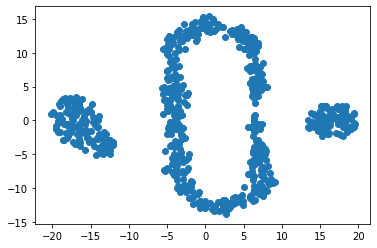

In [39]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])

And using UMAP :

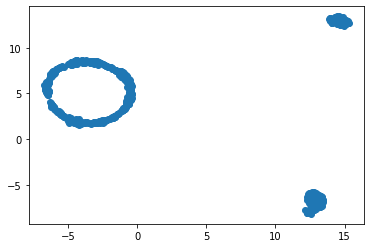

In [40]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])

### Example 2: Mnist dataset

In [41]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [42]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca', 
#                   n_iter=2000, random_state=2233212, 
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

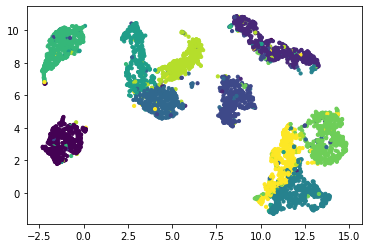

In [43]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)

### Example 3: Fashion_Mnist dataset

In [44]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [45]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca', 
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_fmnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/fmnist.png" width="100%"/> |
 |  -----:| -----:|

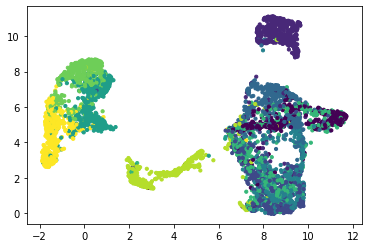

In [46]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)

### Example 4: House prices

In [49]:
data=house_prices_dataset_normed()

In [50]:
# not to run on COLAB

#tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
#                  early_exaggeration=4.0,init='pca', n_iter=1000,
#                  random_state=2233212, metric='euclidean', verbose=100)

#tsne_houses = tsne_model.fit_transform(data)

#plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)
#plt.savefig('t_sne_houses.png')

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_houses.png" width="50%"/>

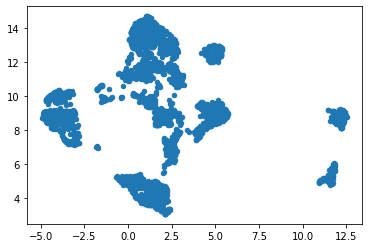

In [51]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analysis and the choice of the modelling data strategy.

**Caveats:** 
- available t-SNE implementations may vary a lot in terms of performance. Computational time can be reduced performing PCA before a t-SNE projection

- UMAP, thanks to the algorithm being amanable to clever initializations and optimization schemes, offers great stability and scaling properties

- UMAP, even if starting from a local picture, is generally more able to spread apart different clusters

- The result of an embedding may depend on the values of the metaparameters. One should try to see how the final embedding changes in order to get to a complete picture